# Cell type annotation from marker genes

Reference from: [https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html](https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html)

In [1]:
import scanpy as sc
import decoupler as dc
import numpy as np

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

/Users/ckuo/github/dobioinformatics/scRNAseq-annotation/decoupler/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.datasets.pbmc3k()
adata

100%|██████████| 5.58M/5.58M [00:01<00:00, 3.84MB/s]


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

/Users/ckuo/github/dobioinformatics/scRNAseq-annotation/decoupler/.pixi/envs/default/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


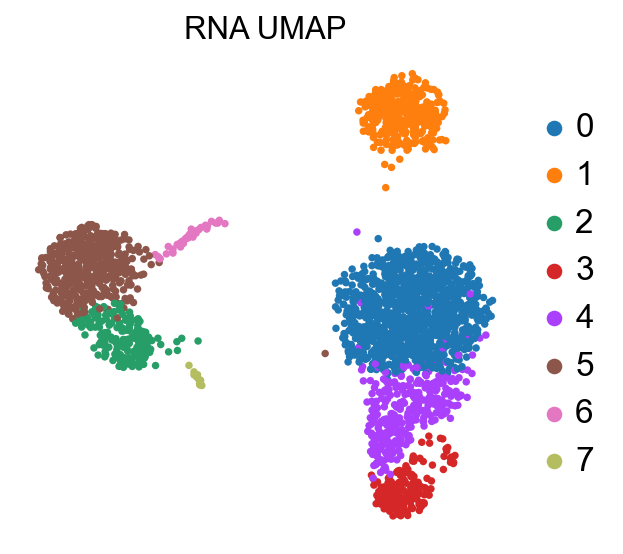

In [5]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [6]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

56.5kB [00:00, 52.0MB/s]
5.91MB [00:00, 25.3MB/s]


,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [7]:
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
14,PRSS3,True,Acinar cells,Endoderm,True,0.833333,0.028931,True,0.028571,0.000000,9606,Pancreas,0.006
15,CELA3A,True,Acinar cells,Endoderm,True,0.833333,0.000000,True,0.128571,0.000000,9606,Pancreas,0.001
17,PRSS1,True,Acinar cells,Endoderm,True,1.000000,0.005975,True,0.028571,0.000000,9606,Pancreas,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,TRBC2,True,T cells,Mesoderm,True,0.940711,0.083362,True,0.000000,0.000000,9606,Immune system,0.066
8266,TRAC,True,T cytotoxic cells,Mesoderm,True,1.000000,0.131348,True,0.000000,0.000000,9606,Immune system,0.042
8267,TRAC,True,T cells,Mesoderm,True,0.972332,0.059544,True,0.000000,0.000000,9606,Immune system,0.042
8297,LCK,True,T cells,Mesoderm,True,0.648221,0.033004,True,0.705607,0.030902,9606,Immune system,0.048


In [8]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 36 sources.


100%|██████████| 2638/2638 [00:01<00:00, 2377.07it/s]


In [10]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Dendritic cells,Ductal cells,Endothelial cells,Enterocytes,Ependymal cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACATACAACCAC-1,-0.000000,1.356127,0.885021,4.065376,2.641014,5.720316,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,0.885021,2.538999,0.437907,1.871866,-0.000000,-0.0,-0.0,-0.0,11.728494
AAACATTGAGCTAC-1,-0.000000,-0.000000,0.885021,5.618952,13.894150,13.010816,0.885021,0.827013,-0.000000,-0.000000,...,-0.0,0.885021,5.279244,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581
AAACATTGATCAGC-1,-0.000000,0.530653,0.885021,1.542530,6.107693,4.530375,-0.000000,0.298770,-0.000000,-0.000000,...,-0.0,2.171878,2.538999,0.437907,3.976687,-0.000000,-0.0,-0.0,-0.0,11.728494
AAACCGTGCTTCCG-1,0.613213,0.530653,0.885021,2.703919,2.641014,22.778754,0.885021,0.827013,-0.000000,0.885021,...,-0.0,0.885021,2.538999,-0.000000,8.019237,0.613213,-0.0,-0.0,-0.0,1.957728
AAACCGTGTATGCG-1,-0.000000,-0.000000,0.885021,1.542530,0.943623,9.831072,-0.000000,0.298770,0.795482,-0.000000,...,-0.0,0.885021,0.569257,0.437907,2.858756,-0.000000,-0.0,-0.0,-0.0,1.957728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.613213,1.356127,0.885021,4.065376,2.641014,25.194302,0.885021,1.527899,-0.000000,-0.000000,...,-0.0,0.885021,2.538999,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581
TTTCTACTGAGGCA-1,-0.000000,-0.000000,0.885021,4.065376,2.641014,8.373145,2.171878,0.827013,-0.000000,-0.000000,...,-0.0,0.885021,8.735716,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581
TTTCTACTTCCTCG-1,-0.000000,-0.000000,0.885021,9.375833,17.770927,14.738433,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,-0.000000,3.822062,1.146495,2.858756,-0.000000,-0.0,-0.0,-0.0,2.981581
TTTGCATGAGAGGC-1,-0.000000,-0.000000,-0.000000,5.618952,7.468516,11.376327,-0.000000,-0.000000,0.795482,0.885021,...,-0.0,0.885021,1.443226,1.146495,2.858756,-0.000000,-0.0,-0.0,-0.0,2.981581


In [11]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 2638 × 36
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

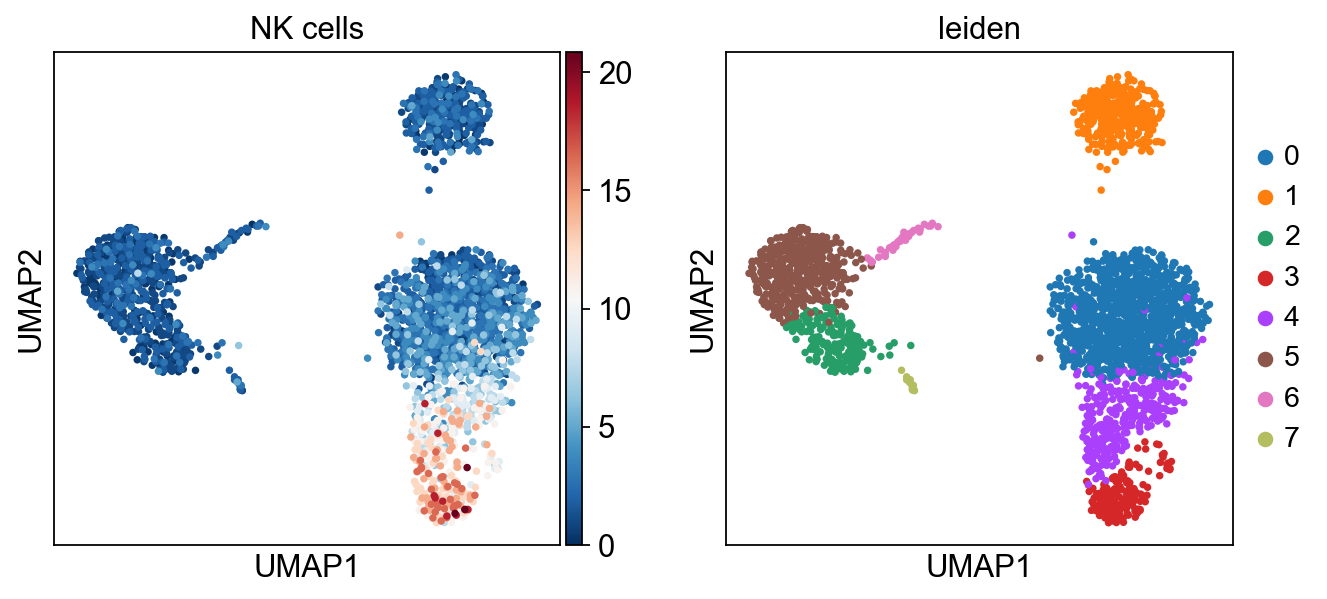

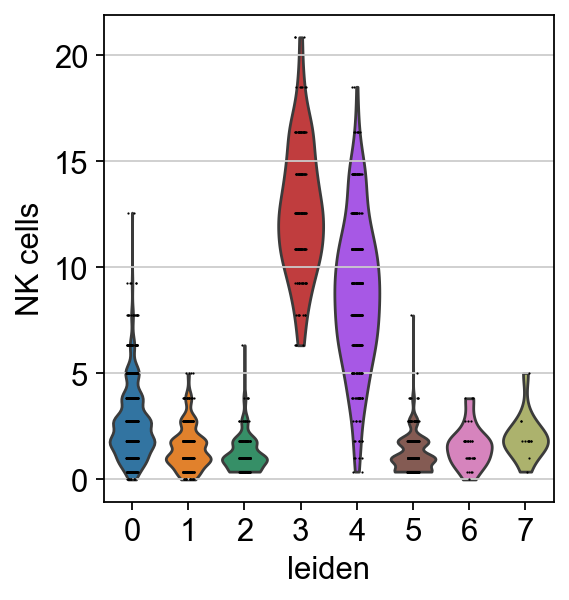

In [12]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

In [13]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,41.247918,5.483099,1.696378e-277,6.106962e-276
1,0,rest,Neurons,8.113397,0.150562,8.106498e-16,1.716670e-15
2,0,rest,Pericytes,4.179567,0.086316,3.031621e-05,4.960835e-05
3,0,rest,Erythroid-like and erythroid precursor cells,3.972203,0.054590,7.345094e-05,1.149667e-04
4,0,rest,Oligodendrocytes,2.848065,0.036036,4.438780e-03,5.707003e-03
...,...,...,...,...,...,...,...
283,7,rest,Adipocytes,-2.059547,-0.352965,5.536047e-02,1.107209e-01
284,7,rest,B cells naive,-2.718910,-2.860703,1.690495e-02,3.803615e-02
285,7,rest,B cells,-2.878208,-1.926988,9.934033e-03,2.750963e-02
286,7,rest,Ductal cells,-3.456581,-0.625260,3.285144e-03,1.130539e-02


In [14]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T cells', 'Neurons', 'Pericytes'],
 '1': ['B cells naive', 'B cells', 'Plasma cells'],
 '2': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 '3': ['Gamma delta T cells', 'NK cells', 'Hepatic stellate cells'],
 '4': ['NK cells', 'Gamma delta T cells', 'T cells'],
 '5': ['Neutrophils', 'Dendritic cells', 'Acinar cells'],
 '6': ['Dendritic cells', 'Ductal cells', 'Acinar cells'],
 '7': ['Platelets', 'Pancreatic stellate cells', 'Endothelial cells']}

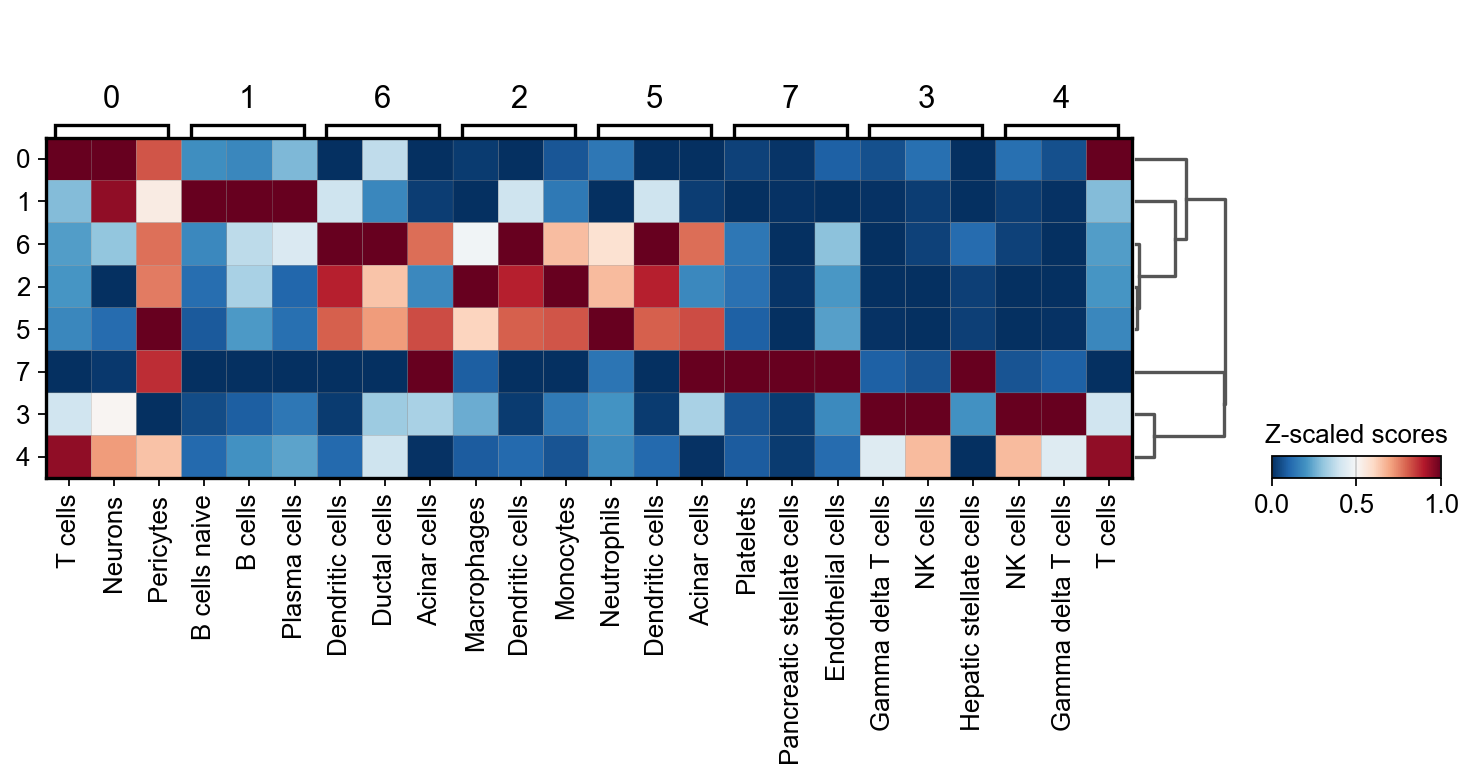

In [15]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

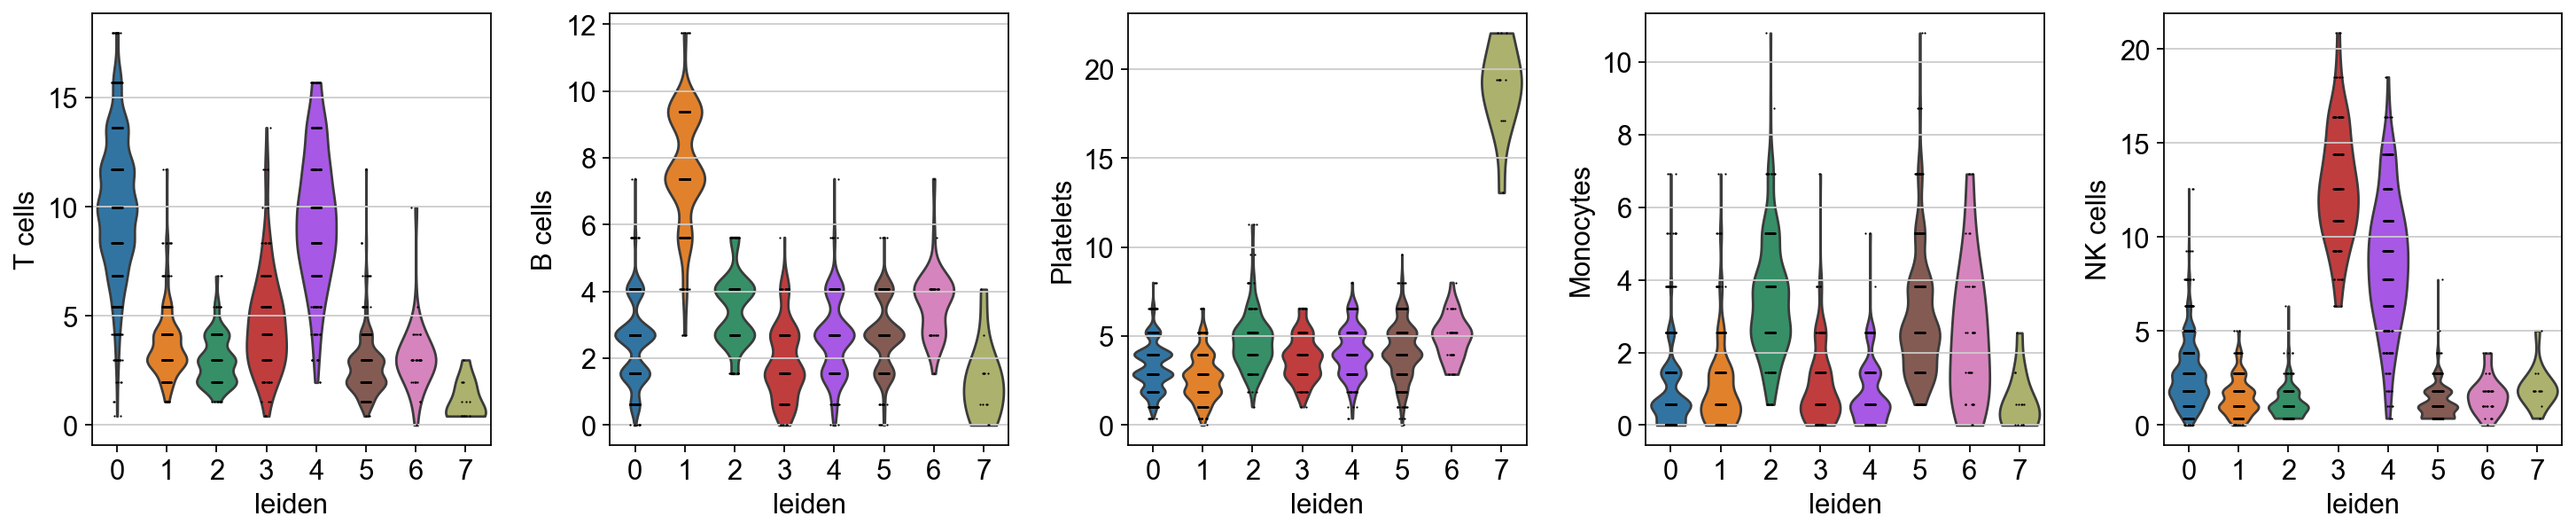

In [16]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

In [17]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'T cells',
 '1': 'B cells naive',
 '2': 'Macrophages',
 '3': 'Gamma delta T cells',
 '4': 'NK cells',
 '5': 'Neutrophils',
 '6': 'Dendritic cells',
 '7': 'Platelets'}

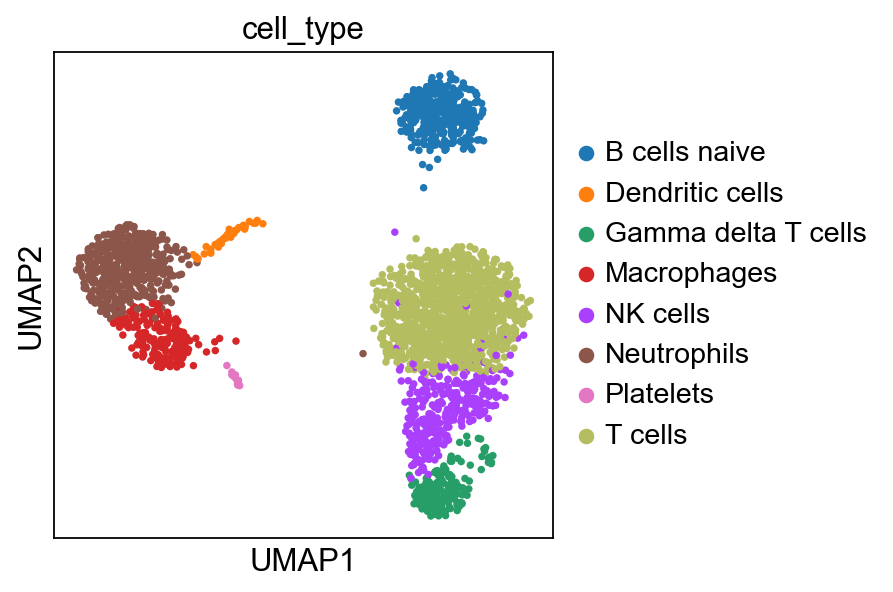

In [18]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')